<a href="https://colab.research.google.com/github/JulioLaz/Movie_Recommender_System_ML/blob/main/Movie_Recommender_System_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




##Imagina tener acceso a los datos de una plataforma de streaming y usar esos datos para mejorar la experiencia del usuario. Como científicos de datos, analizarán estos datos con Python y construirán un recomendador de películas personalizado que ofrecerá sugerencias precisas y relevantes, revolucionando la forma en que los usuarios descubren nuevos contenidos.

### **Objetivos**

1. Recomendador no personalizado

2. Recomendador Content-based

3. Recomendador Collaborative filtering

#**1. Configuración del Ambiente**


---




In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import zipfile
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
global df_movies, df_ratings, df_final
path_img = 'https://i0.wp.com/image.tmdb.org/t/p/w300'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  3613k      0 --:--:-- --:--:-- --:--:-- 3618k


#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
# df_movies.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/movies.csv', index=False)
df_movies = pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/movies.csv')
df_movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
# df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
# df_ratings.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/ratings.csv', index=False)
df_ratings = pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/ratings.csv')
df_ratings.head()

userId  movieId  rating  timestamp
0       1        1    4.00  964982703
1       1        3    4.00  964981247
2       1        6    4.00  964982224
3       1       47    5.00  964983815
4       1       50    5.00  964982931

In [6]:
# df_links = pd.read_csv('data/ml-latest-small/links.csv')
# df_links.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/links.csv', index=False)
df_links = pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/links.csv')
df_links = df_links[['movieId','imdbId']]
df_links['imdbId'] = df_links['imdbId'].apply(lambda x: f"tt{x:07d}")
df_links.head()

movieId     imdbId
0        1  tt0114709
1        2  tt0113497
2        3  tt0113228
3        4  tt0114885
4        5  tt0113041

In [55]:
df_poster=pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/df_merged_poster_links.csv')
df_poster.head()

movieId    imdb_id                       poster_path
0        1  tt0114709  /uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg
1        2  tt0113497  /vgpXmVaVyUL7GGiDeiK1mKEKzcX.jpg
2        3  tt0113228  /1FSXpj5e8l4KH6nVFO5SPUeraOt.jpg
3        4  tt0114885  /4wjGMwPsdlvi025ZqR4rXnFDvBz.jpg
4        5  tt0113041  /rj4LBtwQ0uGrpBnCELr716Qo3mw.jpg

In [7]:
df_merge_movies_links = pd.merge(df_movies, df_links, on='movieId')
df_merge_movies_links.head(2)

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        2    Jumanji (1995)                   Adventure|Children|Fantasy   

      imdbId  
0  tt0114709  
1  tt0113497

In [8]:
df_merge_movies_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
 3   imdbId   9742 non-null   object
dtypes: int64(1), object(3)
memory usage: 304.6+ KB


In [9]:
df_merge_movies_links[df_merge_movies_links['imdbId']==417]

Empty DataFrame
Columns: [movieId, title, genres, imdbId]
Index: []

##**2.2 Tratamiento de Datos**

In [10]:
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
-------------


In [11]:
def preprocesamiento():
    global df_movies, df_ratings, df_final

    df_movies = df_movies.dropna()
    df_ratings = df_ratings.dropna()
    df_movies = df_movies.drop_duplicates(subset=['movieId'])
    df_ratings = df_ratings.drop_duplicates(subset=['movieId', 'userId'])
    df_movies['content'] = df_movies['genres'].str.replace('|', ' ')
    df_movies['genre_set'] = df_movies['genres'].apply(lambda x: set(x.split('|')))

    df_movies['movieId'] = df_movies['movieId'].astype('uint32')
    df_movies['title'] = df_movies['title'].astype(object)
    df_movies['genres'] = df_movies['genres'].astype(object)
    df_movies['content'] = df_movies['content'].astype(object)
    df_movies['genre_set'] = df_movies['genre_set'].astype(object)

    df_ratings['movieId'] = df_ratings['movieId'].astype('uint32')
    df_ratings['userId'] = df_ratings['userId'].astype('uint32')
    df_ratings['rating'] = df_ratings['rating'].astype(float)
    df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

In [12]:
preprocesamiento()
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   uint32
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
dtypes: object(4), uint32(1)
memory usage: 342.6+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  uint32        
 1   movieId    100836 non-null  uint32        
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), uint32(2)
memory usage: 2.3 MB
None
-------------


In [13]:
df_movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   
1                   Adventure Children Fantasy   
2                               Comedy Romance   
3                         Comedy Drama Romance   
4                                       Comedy   

                                           genre_set  
0  {Adventure, Fantasy, Animation, Comedy, Children}  
1                     {Fantasy, Adventure, Children}  
2                                  {Romance, Comedy}  
3                           {Romance, Drama, Comedy}  
4                                           {Comedy}

In [14]:
2**16

65536

In [15]:
import re

df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)') # Extraer el año de la columna title y crear la nueva columna year
df_movies['year'] = df_movies['year'].fillna(0).astype('uint16')
df_movies['title'] = df_movies['title'].str.replace(r'\s*\(\d{4}\)$', '', regex=True) # Dejar sólo el title, eliminando el año:
df_movies.head()
df_movies.head(10)

movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   
5        6                         Heat   
6        7                      Sabrina   
7        8                 Tom and Huck   
8        9                 Sudden Death   
9       10                    GoldenEye   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   
5                        Action|Crime|Thriller   
6                               Comedy|Romance   
7                           Adventure|Children   
8                                       Action   
9                    Action|Adventure|Thriller   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   
1                   Adventure Children Fantasy   
2                               Comedy Romance   
3                         Comedy Drama Romance   
4                                       Comedy   
5                        Action Crime Thriller   
6                               Comedy Romance   
7                           Adventure Children   
8                                       Action   
9                    Action Adventure Thriller   

                                           genre_set  year  
0  {Adventure, Fantasy, Animation, Comedy, Children}  1995  
1                     {Fantasy, Adventure, Children}  1995  
2                                  {Romance, Comedy}  1995  
3                           {Romance, Drama, Comedy}  1995  
4                                           {Comedy}  1995  
5                          {Crime, Thriller, Action}  1995  
6                                  {Romance, Comedy}  1995  
7                              {Adventure, Children}  1995  
8                                           {Action}  1995  
9                      {Adventure, Thriller, Action}  1995

In [16]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   uint32
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
 5   year       9742 non-null   uint16
dtypes: object(4), uint16(1), uint32(1)
memory usage: 361.6+ KB


In [17]:
df_ratings.sample(5)

userId  movieId  rating           timestamp
57498     380     6373    4.00 2017-04-28 22:54:36
76648     480     4025    2.50 2007-05-14 17:55:42
26524     182     2722    0.50 2003-06-09 09:29:18
50442     325     4954    2.00 2002-12-09 01:08:49
87674     564   136598    4.00 2016-11-06 17:11:16

##**2.3 Análisis Exploratorio (EDA)**

In [18]:
df_movies.describe()

movieId    year
count   9742.00 9742.00
mean   42200.35 1991.95
std    52160.49   75.14
min        1.00    0.00
25%     3248.25 1987.00
50%     7300.00 1999.00
75%    76232.00 2008.00
max   193609.00 2018.00

In [19]:
df_ratings.describe()

userId   movieId    rating                      timestamp
count 100836.00 100836.00 100836.00                         100836
mean     326.13  19435.30      3.50  2008-03-19 17:01:27.368469248
min        1.00      1.00      0.50            1996-03-29 18:36:55
25%      177.00   1199.00      3.00            2002-04-18 09:57:46
50%      325.00   2991.00      3.50            2007-08-02 20:31:02
75%      477.00   8122.00      4.00     2015-07-04 07:15:44.500000
max      610.00 193609.00      5.00            2018-09-24 14:27:30
std      182.62  35530.99      1.04                            NaN

##User with the most votes

In [20]:
count_userId=df_ratings['userId'].value_counts()
count_userId.sort_values(ascending=False).head(10)

userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
Name: count, dtype: int64

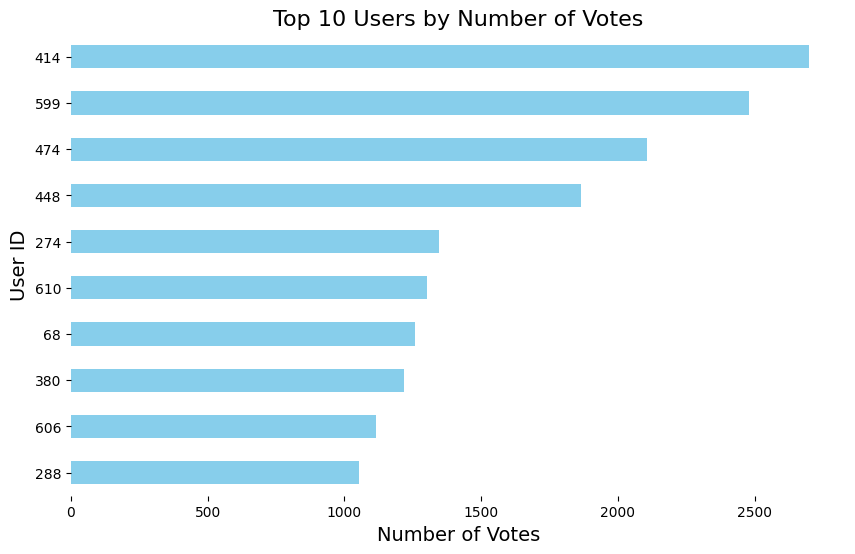

In [21]:
plt.figure(figsize=(10, 6))
count_userId.sort_values(ascending=False).head(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Users by Number of Votes', fontsize=16)
plt.xlabel('Number of Votes', fontsize=14)
plt.ylabel('User ID', fontsize=14)
plt.gca().invert_yaxis()
plt.box(None)
plt.show()

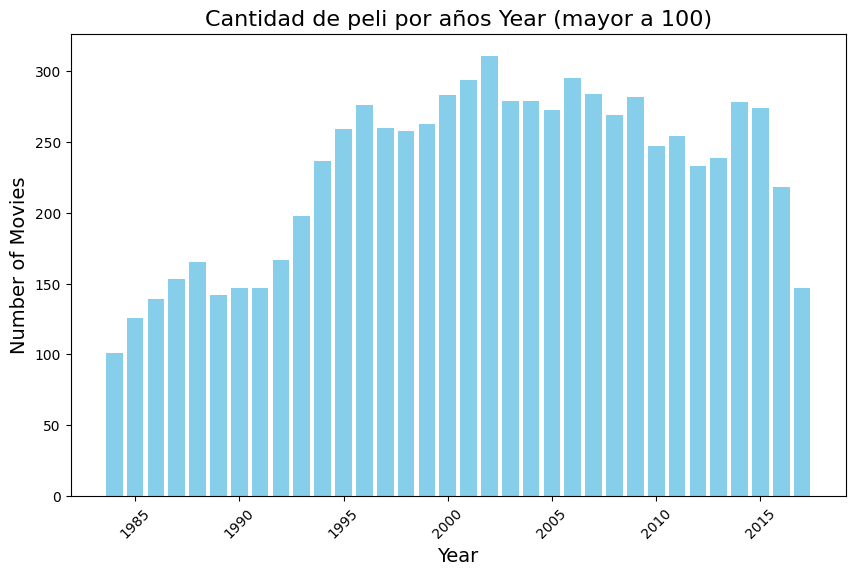

In [22]:
# Histograma del atributo 'years' en df_movies
movie_years=df_movies.groupby('year')['movieId'].count().reset_index()
movie_years=movie_years[movie_years['year']!=0]
movie_years=movie_years[movie_years['movieId']>=100]

plt.figure(figsize=(10, 6))
plt.bar(movie_years['year'], movie_years['movieId'], color='skyblue')

plt.title('Cantidad de peli por años Year (mayor a 100)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45)
plt.show()

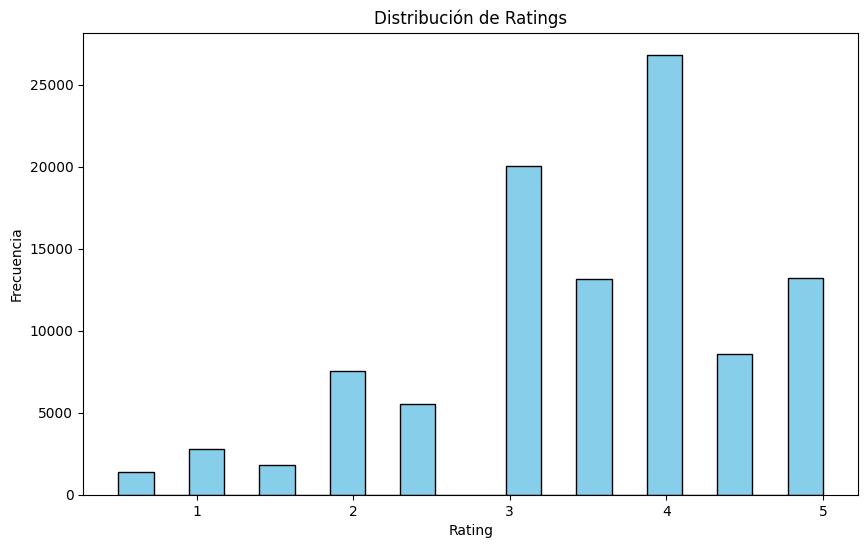

In [23]:
# Histograma del atributo 'rating' en df_ratings
plt.figure(figsize=(10, 6))
plt.hist(df_ratings['rating'], bins=20, edgecolor='black', color='skyblue')
plt.title('Distribución de Ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()


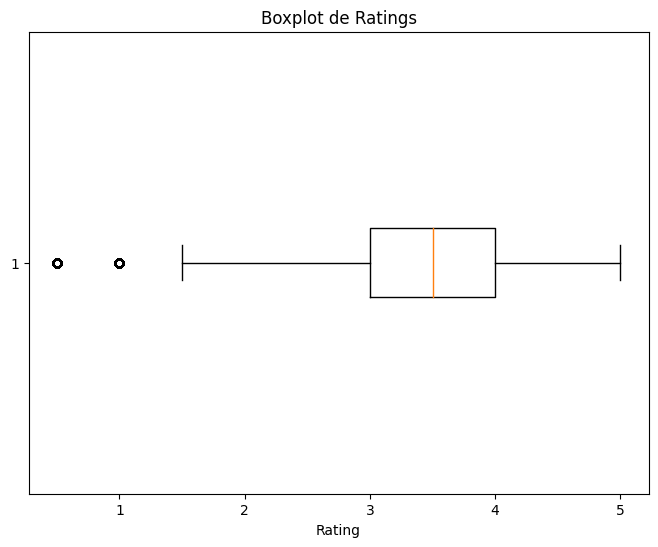

In [24]:
# Boxplot del atributo 'rating' en df_ratings
plt.figure(figsize=(8, 6))
plt.boxplot(df_ratings['rating'], vert=False)
plt.title('Boxplot de Ratings')
plt.xlabel('Rating')
plt.show()


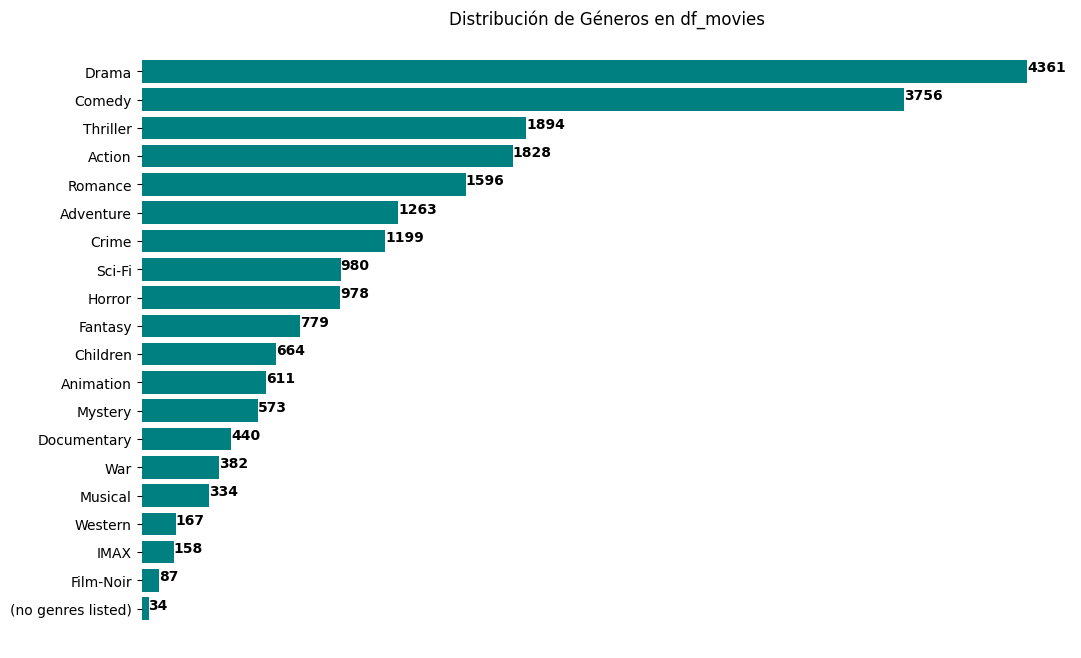

In [25]:
from collections import Counter # Contar la frecuencia de cada género en df_movies

genres = df_movies['genres'].str.split('|').explode()
genre_counts = Counter(genres)
df_genres = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['Count'])
df_genres.sort_values(by='Count', ascending=True, inplace=True)

plt.figure(figsize=(12, 8))
plt.barh(df_genres.index, df_genres.Count, color='teal')

for i, v in enumerate(df_genres.Count):
    plt.text(v, i, str(v), color='black', fontweight='bold')

plt.title('Distribución de Géneros en df_movies')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.box(False)
plt.show()


In [26]:
df_final = pd.merge(df_ratings, df_movies, on='movieId')
df_final.dropna(inplace=True)
df_final.head()

userId  movieId  rating           timestamp      title  \
0       1        1    4.00 2000-07-30 18:45:03  Toy Story   
1       5        1    4.00 1996-11-08 06:36:02  Toy Story   
2       7        1    4.50 2005-01-25 06:52:26  Toy Story   
3      15        1    2.50 2017-11-13 12:59:30  Toy Story   
4      17        1    4.50 2011-05-18 05:28:03  Toy Story   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1  Adventure|Animation|Children|Comedy|Fantasy   
2  Adventure|Animation|Children|Comedy|Fantasy   
3  Adventure|Animation|Children|Comedy|Fantasy   
4  Adventure|Animation|Children|Comedy|Fantasy   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   
1  Adventure Animation Children Comedy Fantasy   
2  Adventure Animation Children Comedy Fantasy   
3  Adventure Animation Children Comedy Fantasy   
4  Adventure Animation Children Comedy Fantasy   

                                           genre_set  year  
0  {Adventure, Fantasy, Animation, Comedy, Children}  1995  
1  {Adventure, Fantasy, Animation, Comedy, Children}  1995  
2  {Adventure, Fantasy, Animation, Comedy, Children}  1995  
3  {Adventure, Fantasy, Animation, Comedy, Children}  1995  
4  {Adventure, Fantasy, Animation, Comedy, Children}  1995

In [27]:
df_final.describe()

userId   movieId    rating                      timestamp      year
count 100836.00 100836.00 100836.00                         100836 100836.00
mean     326.13  19435.30      3.50  2008-03-19 17:01:27.368469504   1994.09
min        1.00      1.00      0.50            1996-03-29 18:36:55      0.00
25%      177.00   1199.00      3.00            2002-04-18 09:57:46   1990.00
50%      325.00   2991.00      3.50            2007-08-02 20:31:02   1997.00
75%      477.00   8122.00      4.00     2015-07-04 07:15:44.500000   2003.00
max      610.00 193609.00      5.00            2018-09-24 14:27:30   2018.00
std      182.62  35530.99      1.04                            NaN     30.27

In [28]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  uint32        
 1   movieId    100836 non-null  uint32        
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
 4   title      100836 non-null  object        
 5   genres     100836 non-null  object        
 6   content    100836 non-null  object        
 7   genre_set  100836 non-null  object        
 8   year       100836 non-null  uint16        
dtypes: datetime64[ns](1), float64(1), object(4), uint16(1), uint32(2)
memory usage: 5.6+ MB


In [29]:
df_title_count_votes = df_final.groupby('title')['userId'].count().reset_index().nlargest(10, 'userId')
df_title_count_votes.rename(columns={'userId': 'count_votes'}, inplace=True)
df_title_count_votes

title  count_votes
3072                        Forrest Gump          329
7368           Shawshank Redemption, The          317
6657                        Pulp Fiction          307
7454           Silence of the Lambs, The          279
5348                         Matrix, The          278
7767  Star Wars: Episode IV - A New Hope          251
4521                       Jurassic Park          238
1301                          Braveheart          237
8125          Terminator 2: Judgment Day          224
7199                    Schindler's List          220

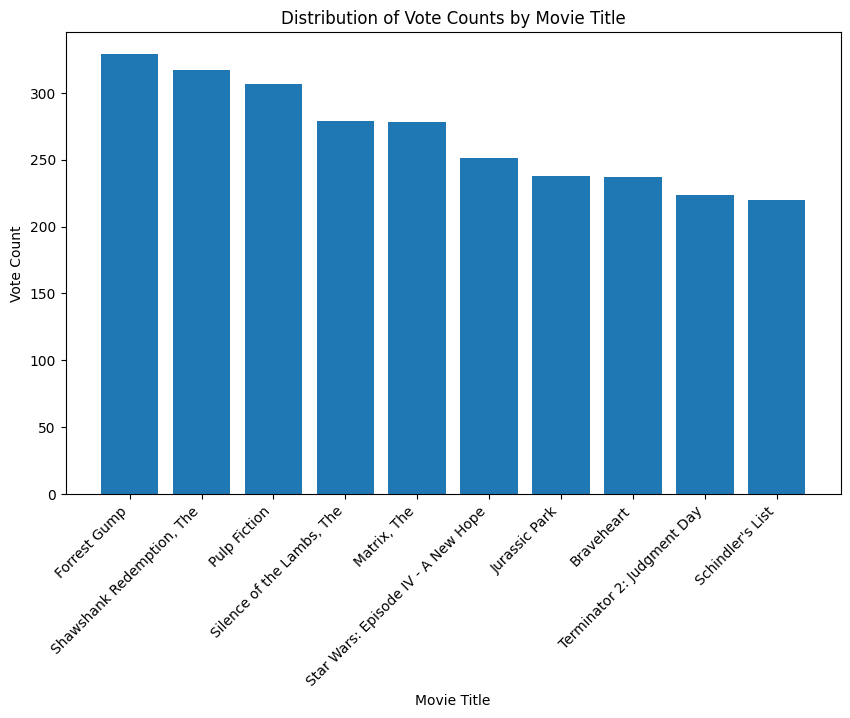

In [30]:
plt.figure(figsize=(10, 6))
plt.bar(df_title_count_votes['title'], df_title_count_votes['count_votes'])
plt.xlabel('Movie Title')
plt.ylabel('Vote Count')
plt.title('Distribution of Vote Counts by Movie Title')
plt.xticks(rotation=45, ha='right')
plt.show()

In [31]:
#agrupar por title con promedio de rating:

df_title_rating = df_final.groupby('title')['rating'].mean().reset_index()
df_title_rating.rename(columns={'rating': 'mean_rating'}, inplace=True)
df_title_rating.sort_values(by='mean_rating', ascending=False, inplace=True)
df_title_rating.sample(10)

title  mean_rating
2725                                      Evan Almighty         2.54
589                              Art of Getting By, The         3.00
4684  Koyaanisqatsi (a.k.a. Koyaanisqatsi: Life Out ...         3.86
5622                                         Moonstruck         3.56
4897     Librarian: Return to King Solomon's Mines, The         3.50
7233                                         Seabiscuit         3.69
472             And Your Mother Too (Y tu mamá también)         3.95
1318                                 Breaking the Waves         4.07
7837                                              Stone         3.25
1985                                       Crimson Tide         3.64

#**3. Estrategias de Recomendación**


---




##**3.1 Recomendación no personalizada**

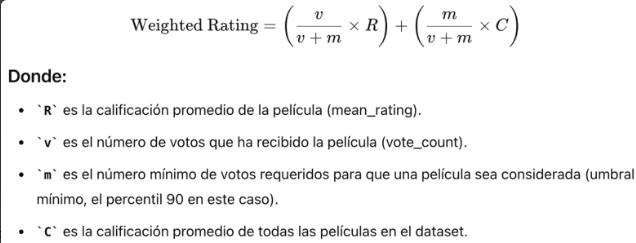

In [51]:
df_final.head(1)

userId  movieId  rating           timestamp      title  \
0       1        1    4.00 2000-07-30 18:45:03  Toy Story   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   

                                           genre_set  year  
0  {Adventure, Fantasy, Animation, Comedy, Children}  1995

In [58]:
def recomendacion_populares():
    vote_counts = df_final['title'].value_counts()
    df_popular_movies = df_final[df_final['title'].isin(vote_counts[vote_counts > 210].index)]
    df_movie_stats = df_popular_movies.groupby(['title','movieId','year']).agg(
        mean_rating=('rating', 'mean'),
        vote_count=('title', 'count')
    ).reset_index()

    m = df_movie_stats['vote_count'].quantile(.9) # Calcular el número mínimo de votos requeridos (m)
    C = df_final['rating'].mean()  # Calcular la calificación promedio de todas las películas (C)
    df_movie_stats['bayesian_average'] = (df_movie_stats['vote_count'] / (df_movie_stats['vote_count'] + m)) * df_movie_stats['mean_rating'] + (m / (df_movie_stats['vote_count'] + m)) * C
    df_movie_stats = df_movie_stats.nlargest(10, 'bayesian_average')
    return df_movie_stats

In [59]:
recomendacion_populares= recomendacion_populares()
df_poster_pop = pd.merge(recomendacion_populares, df_poster, on='movieId', how='left')
df_poster_pop

title  movieId  year  mean_rating  \
0                       Shawshank Redemption, The      318  1994         4.43   
1                                    Pulp Fiction      296  1994         4.20   
2                                    Forrest Gump      356  1994         4.16   
3                                     Matrix, The     2571  1999         4.19   
4              Star Wars: Episode IV - A New Hope      260  1977         4.23   
5                                      Fight Club     2959  1999         4.27   
6                       Silence of the Lambs, The      593  1991         4.16   
7                                Schindler's List      527  1993         4.22   
8  Star Wars: Episode V - The Empire Strikes Back     1196  1980         4.22   
9                                      Braveheart      110  1995         4.03   

   vote_count  bayesian_average    imdb_id                       poster_path  
0         317              3.97  tt0111161  /lyQBXzOQSuE59IsHyhrp0qIiPAz.jpg  
1         307              3.84  tt0110912  /d5iIlFn5s0ImszYzBPb8JPIfbXD.jpg  
2         329              3.84  tt0109830  /arw2vcBveWOVZr6pxd9XTd1TdQa.jpg  
3         278              3.83  tt0133093  /f89U3ADr1oiB1s9GkdPOEpXUk5H.jpg  
4         251              3.83  tt0076759  /6FfCtAuVAW8XJjZ7eWeLibRLWTw.jpg  
5         218              3.82  tt0137523  /pB8BM7pdSp6B6Ih7QZ4DrQ3PmJK.jpg  
6         279              3.81  tt0102926  /uS9m8OBk1A8eM9I042bx8XXpqAq.jpg  
7         220              3.80  tt0108052  /sF1U4EUQS8YHUYjNl3pMGNIQyr0.jpg  
8         211              3.79  tt0080684  /nNAeTmF4CtdSgMDplXTDPOpYzsX.jpg  
9         237              3.73  tt0112573   /or1gBugydmjToAEq7OZY0owwFk.jpg

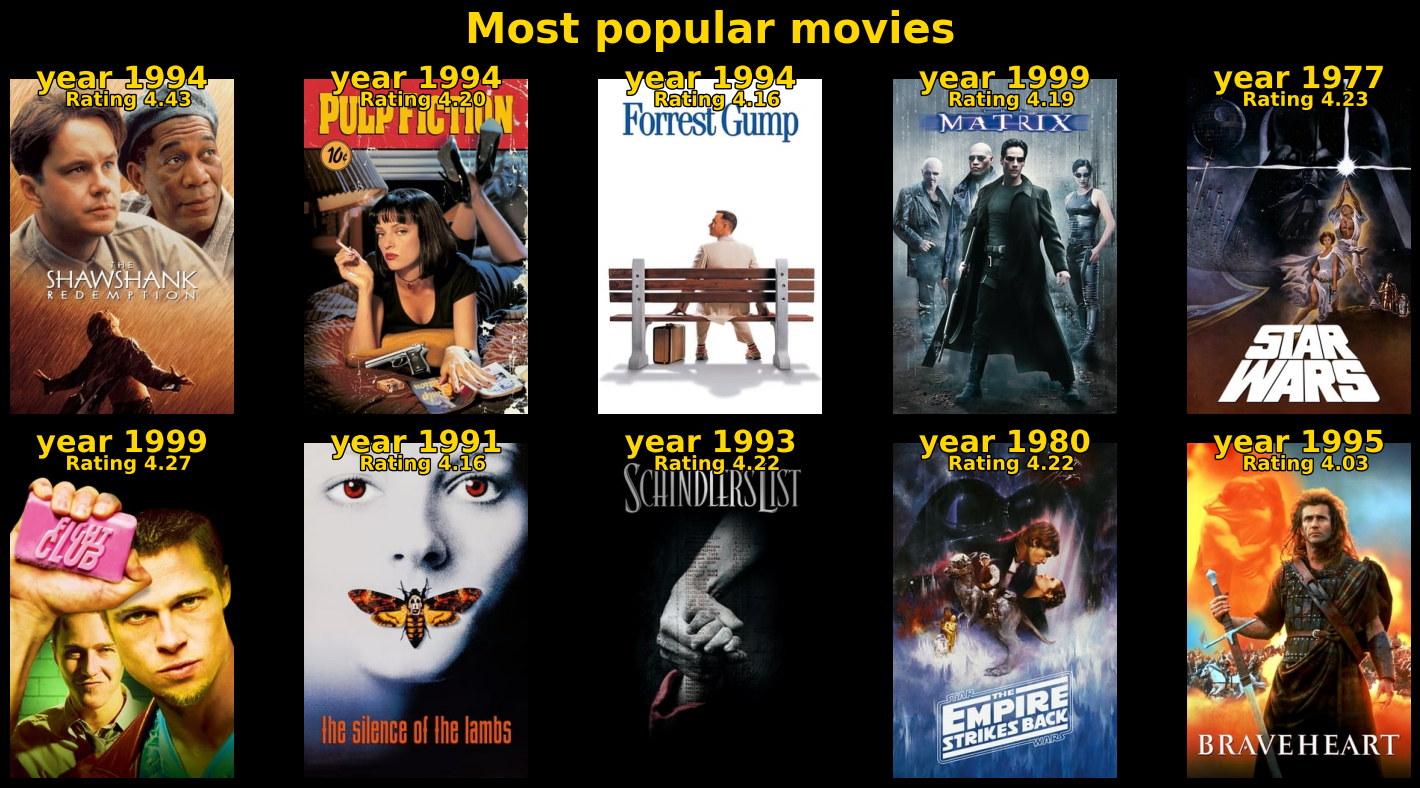

In [66]:
from PIL import Image
import requests
import matplotlib.patheffects as patheffects
from io import BytesIO

df_poster_pop['poster_path'] = df_poster_pop['poster_path'].apply(lambda x: f"{path_img}{x}")

image_urls = list(df_poster_pop.poster_path)

fig, axes = plt.subplots(2, 5, figsize=(15, 8), facecolor='black', sharex=True, sharey=True)

for idx, (ax, img_url,year,averageRating) in enumerate(zip(axes.flatten(), image_urls, df_poster_pop['year'], df_poster_pop['mean_rating']), start=1):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.text(150, 0, f'year {year}', color='gold', fontsize=22, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
    ax.text(159, 28, f'Rating {averageRating:.2f}', color='gold', fontsize=14, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

fig.suptitle(f'Most popular movies', fontsize=30, color='gold', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 1])
# plt.savefig(f'/content/drive/MyDrive/Bootcamp-Alejo-projects/Movie_Analysis/graficas/movie_pop.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

##**3.2 Recomendación Content-Based**

###**3.2.1 Similitud de Jaccard**

In [76]:
def similitud_jaccard(set1, set2):
    """Calcula la similitud de Jaccard entre dos conjuntos."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

def recomendacion_jaccard(movie_id, df, n_recommendations=10):
    input_features = df[df['movieId'] == movie_id]['genre_set'].values[0]
    df['similaridad'] = df['genre_set'].apply(lambda x: similitud_jaccard(input_features, x))
    df.sort_values('similaridad', ascending=False, inplace=True)
    df=df.nlargest(10,'similaridad')
    df.sort_values('year', ascending=False, inplace=True)
    df_average_ratings=df_ratings.groupby('movieId')['rating'].mean().reset_index()
    df_poster_jaccard = pd.merge(df, df_average_ratings, on='movieId', how='left')
    return df_poster_jaccard


In [77]:
recomendaciones_jaccard = recomendacion_jaccard(58559, df_movies, n_recommendations=10)
df_poster_jaccard = pd.merge(recomendaciones_jaccard, df_poster, on='movieId', how='left')
df_poster_jaccard

movieId                                    title  \
0   109850                           Need for Speed   
1    86644  Fast Five (Fast and the Furious 5, The)   
2    82744                                   Faster   
3    58559                         Dark Knight, The   
4    73876         Undisputed II: Last Man Standing   
5    33132                         State Property 2   
6     6484                       Hollywood Homicide   
7    80124                        Sisters (Syostry)   
8     4488                                   Colors   
9    26464                             Blue Thunder   

                             genres                           content  \
0           Action|Crime|Drama|IMAX           Action Crime Drama IMAX   
1  Action|Crime|Drama|Thriller|IMAX  Action Crime Drama Thriller IMAX   
2                Action|Crime|Drama                Action Crime Drama   
3           Action|Crime|Drama|IMAX           Action Crime Drama IMAX   
4                Action|Crime|Drama                Action Crime Drama   
5                Action|Crime|Drama                Action Crime Drama   
6                Action|Crime|Drama                Action Crime Drama   
7                Action|Crime|Drama                Action Crime Drama   
8                Action|Crime|Drama                Action Crime Drama   
9                Action|Crime|Drama                Action Crime Drama   

                                genre_set  year  similaridad  rating  \
0            {IMAX, Drama, Crime, Action}  2014         1.00    3.75   
1  {Drama, Action, IMAX, Crime, Thriller}  2011         0.80    3.05   
2                  {Drama, Crime, Action}  2010         0.75    5.00   
3            {IMAX, Drama, Crime, Action}  2008         1.00    4.24   
4                  {Drama, Crime, Action}  2006         0.75    4.00   
5                  {Drama, Crime, Action}  2005         0.75    1.50   
6                  {Drama, Crime, Action}  2003         0.75    2.93   
7                  {Drama, Crime, Action}  2001         0.75    5.00   
8                  {Drama, Crime, Action}  1988         0.75    3.33   
9                  {Drama, Crime, Action}  1983         0.75    3.00   

     imdb_id                       poster_path  
0  tt2369135  /z42kyMizgDKetejusZgucSQsQ4l.jpg  
1  tt1596343  /c5rgA1EYwMmxsQdyvLkQ8LD5Qun.jpg  
2  tt1433108  /AsUeaXrhw4oscCSjUZ6heh1pVvd.jpg  
3  tt0468569  /qJ2tW6WMUDux911r6m7haRef0WH.jpg  
4  tt0443676  /4bE9t5ctBZXYV3GJ6Xr0l4KRplv.jpg  
5  tt0403537  /plp9AHFlFghfmMESJyPmsJnhQao.jpg  
6  tt0329717  /Am7AhZYG7HLksY5E35oaEJ3Desz.jpg  
7  tt0284492  /8FP5YGUFTUhuVnJeUYOeIspi4Xe.jpg  
8  tt0094894  /5KueYME8A449pxaKTJZp3cWKKSX.jpg  
9  tt0085255  /9tdoGRA7FNCuj1zhKDNLWpab9v5.jpg

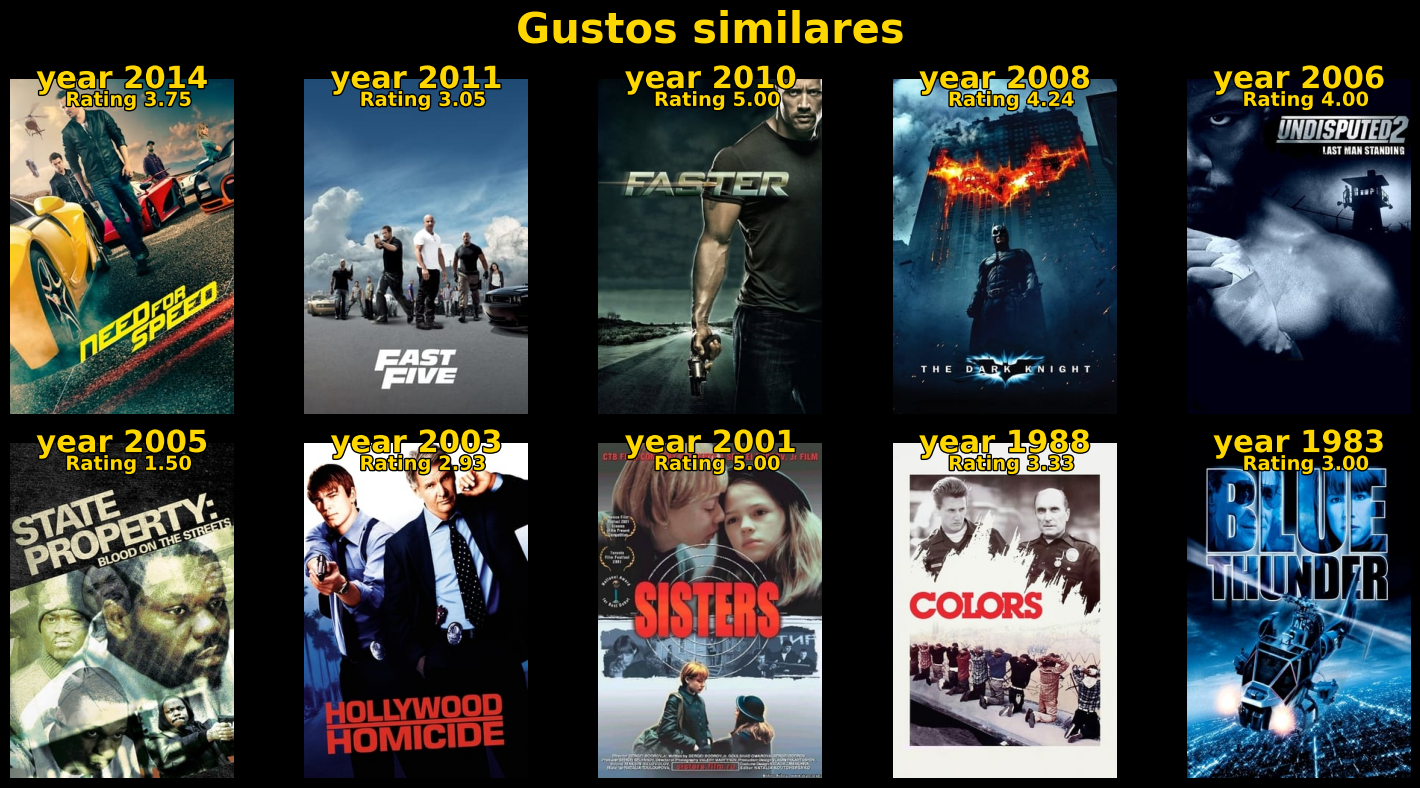

In [80]:
from PIL import Image
import requests
import matplotlib.patheffects as patheffects
from io import BytesIO
df=df_poster_jaccard.copy()
df['poster_path'] = df['poster_path'].apply(lambda x: f"{path_img}{x}")

image_urls = list(df.poster_path)

fig, axes = plt.subplots(2, 5, figsize=(15, 8), facecolor='black', sharex=True, sharey=True)

for idx, (ax, img_url,year,averageRating) in enumerate(zip(axes.flatten(), image_urls, df['year'], df['rating']), start=1):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.text(150, 0, f'year {year}', color='gold', fontsize=22, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
    ax.text(159, 28, f'Rating {averageRating:.2f}', color='gold', fontsize=14, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

fig.suptitle(f'Gustos similares', fontsize=30, color='gold', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 1])
# plt.savefig(f'/content/drive/MyDrive/Bootcamp-Alejo-projects/Movie_Analysis/graficas/movie_pop.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

###**3.2.2 Similitud de Coseno con TF-IDF**

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
feature_vectors = vectorizer.fit_transform(df_movies['content'])
cosine_sim = cosine_similarity(feature_vectors,feature_vectors)

In [37]:
df_movies.head(1)

movieId           title                   genres  \
8387   109850  Need for Speed  Action|Crime|Drama|IMAX   

                      content                     genre_set  year  similaridad  
8387  Action Crime Drama IMAX  {IMAX, Drama, Crime, Action}  2014         1.00

In [38]:
def recomendacion_tf_idf(movie_id, df_movies, cosine_sim, n_recommendations=10):
    idx = df_movies[df_movies['movieId'] == movie_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [x for x in sim_scores if x[0] != idx]
    movie_indices = [x[0] for x in sim_scores[:n_recommendations]]
    recommended_movies = df_movies.iloc[movie_indices]
    recommended_movies = recommended_movies.copy()
    recommended_movies['distance'] = [x[1] for x in sim_scores[:n_recommendations]]
    return recommended_movies

In [39]:
recomendaciones_tfidf = recomendacion_tf_idf(1, df_movies, cosine_sim, n_recommendations=10)
recomendaciones_tfidf

movieId                                           title  \
6710    58559                                Dark Knight, The   
5917    33794                                   Batman Begins   
7599    86644         Fast Five (Fast and the Furious 5, The)   
6852    62081                                       Eagle Eye   
8103   100498                         Good Day to Die Hard, A   
8166   102716  Fast & Furious 6 (Fast and the Furious 6, The)   
8149   102088              Grandmaster, The (Yi dai zong shi)   
7768    91529                          Dark Knight Rises, The   
8233   104129                                  Man of Tai Chi   
8201   103339                                White House Down   

                                genres                           content  \
6710           Action|Crime|Drama|IMAX           Action Crime Drama IMAX   
5917                 Action|Crime|IMAX                 Action Crime IMAX   
7599  Action|Crime|Drama|Thriller|IMAX  Action Crime Drama Thriller IMAX   
6852        Action|Crime|Thriller|IMAX        Action Crime Thriller IMAX   
8103        Action|Crime|Thriller|IMAX        Action Crime Thriller IMAX   
8166        Action|Crime|Thriller|IMAX        Action Crime Thriller IMAX   
8149                 Action|Drama|IMAX                 Action Drama IMAX   
7768       Action|Adventure|Crime|IMAX       Action Adventure Crime IMAX   
8233                       Action|IMAX                       Action IMAX   
8201        Action|Drama|Thriller|IMAX        Action Drama Thriller IMAX   

                                   genre_set  year  similaridad  distance  
6710            {IMAX, Drama, Crime, Action}  2008         1.00      1.00  
5917                   {IMAX, Crime, Action}  2005         0.75      0.96  
7599  {Drama, Action, IMAX, Crime, Thriller}  2011         0.80      0.93  
6852         {IMAX, Crime, Thriller, Action}  2008         0.60      0.89  
8103         {IMAX, Crime, Thriller, Action}  2013         0.60      0.89  
8166         {IMAX, Crime, Thriller, Action}  2013         0.60      0.89  
8149                   {IMAX, Drama, Action}  2013         0.75      0.89  
7768        {IMAX, Adventure, Crime, Action}  2012         0.60      0.87  
8233                          {IMAX, Action}  2013         0.50      0.85  
8201         {IMAX, Drama, Thriller, Action}  2013         0.60      0.82

##**3.3 Recomendación Collaborative Filtering**

In [40]:
#importar NearestNeighbors:
from sklearn.neighbors import NearestNeighbors
ratings_matrix = df_final.pivot(index='userId', columns='movieId', values='rating')
avg_ratings = ratings_matrix.mean(axis=1)
ratings_matrix_normalized = ratings_matrix.sub(avg_ratings, axis=0).fillna(0)
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(ratings_matrix_normalized.values)

NearestNeighbors(algorithm='brute', metric='cosine')

In [41]:
def recomendacion_knn(user_input, df_final, ratings_matrix_normalized, n_recommendations=10):
    if isinstance(user_input, int):
        print('Existing user',type(user_input))
        idx = ratings_matrix_normalized.index.get_loc(user_input)
        distances, indices = knn_model.kneighbors(ratings_matrix_normalized.iloc[idx].values.reshape(1, -1), n_neighbors=n_recommendations + 1)
    else:
        print('New user',type(user_input))
        new_user_ratings = pd.Series(0, index=ratings_matrix_normalized.columns)
        new_user_ratings.update(usuario)
        user_mean = new_user_ratings[new_user_ratings != 0].mean() # Calculo la media de las calificaciones del usuario
        new_user_ratings_normalized = new_user_ratings.sub(user_mean).fillna(0) # Normalizo calificaciones del usuario
        distances, indices = knn_model.kneighbors(new_user_ratings_normalized.values.reshape(1, -1), n_neighbors=n_recommendations + 1)

    distances = distances.flatten()[1:]# del first element
    indices = indices.flatten()[1:]

    similar_users = ratings_matrix_normalized.iloc[indices] #peli de usuarios similares

    mean_ratings = similar_users.T.dot(distances) / np.sum(distances) #promedio de ratings
    df_mean_ratings = pd.DataFrame(mean_ratings, index=ratings_matrix_normalized.columns, columns=['mean_rating'])
    df_mean_ratings = df_mean_ratings.dropna()

    ### Filtrar peli ya vistas por el user:
    if isinstance(user_input, int):
        movies_seen = df_final[df_final['userId']==user_input].index
        df_mean_ratings = df_mean_ratings[~df_mean_ratings.index.isin(movies_seen)]

    df_mean_ratings = df_mean_ratings.sort_values('mean_rating', ascending=False)

    recommended_movies = pd.merge(df_mean_ratings, df_final[['movieId', 'title', 'content']], left_index=True, right_on='movieId')
    recommended_movies.drop_duplicates(subset=['movieId'], inplace=True)
    columnas=['movieId', 'title', 'content','mean_rating']
    return recommended_movies[columnas].head(n_recommendations)

In [42]:
usuario = pd.Series({
    356: 4,
    58559: 5
})
# usuario=15
recomendacion_knn(usuario,df_final, ratings_matrix_normalized, n_recommendations=10)

New user <class 'pandas.core.series.Series'>


movieId                                  title  \
2426       356                           Forrest Gump   
17064    58559                       Dark Knight, The   
16296      318              Shawshank Redemption, The   
12642     2571                            Matrix, The   
4310       593              Silence of the Lambs, The   
3570       527                       Schindler's List   
50036     7361  Eternal Sunshine of the Spotless Mind   
50361     1036                               Die Hard   
18704     3949                    Requiem for a Dream   
32865      587                                  Ghost   

                                     content  mean_rating  
2426                Comedy Drama Romance War         1.05  
17064                Action Crime Drama IMAX         0.72  
16296                            Crime Drama         0.51  
12642                 Action Sci-Fi Thriller         0.49  
4310                   Crime Horror Thriller         0.46  
3570                               Drama War         0.32  
50036                   Drama Romance Sci-Fi         0.28  
50361                  Action Crime Thriller         0.27  
18704                                  Drama         0.23  
32865  Comedy Drama Fantasy Romance Thriller         0.23

In [43]:
#@title
# def recomendacion_knn(usuario_id_o_ratings, ratings_matrix_normalized, ratings_matrix, df_movies, knn_model, n_recommendations=10):
#   #Tu código aquí
#   return recommendations
